# TSF

> Time series forecasting to approach the problem of predicting density distributions

We start simple, just taking the beginning of one simulation from one scenario
and trying to predict the end of the simulation. Only for one phase space.
The 2 dimensions of the phase space can be flattened to transform the problem
into a nominal tsf problem

In [1]:
from tsai.basics import *
import scipy.io


In [2]:
config = AttrDict(
    bs=64, # batch size
    epochs=100, # max number of epochs
    lookback=10, # number of previous steps to consider
    horizon=1, # number of steps into the future
    max_lr=None, # If None, lr_find will be called
    seed=42, # random seed
    stride=1, # number of steps between two consecutive windows
    wd=0., # weight decay
)

In [3]:
data = scipy.io.loadmat('../data/SommaMult_3_x10_x10_0215_1_part_1_density.mat')
# Remove every key starting with '__' from the dictionary
data = {k: v for k, v in data.items() if not k.startswith('__')}
for k, v in data.items():
    print(k, type(v), v.shape)

MCconfig <class 'numpy.ndarray'> (1, 1)
param <class 'numpy.ndarray'> (1, 1)
paramSSEM <class 'numpy.ndarray'> (1, 1)
time_density <class 'numpy.ndarray'> (122, 1)
ra_disc <class 'numpy.ndarray'> (1, 37)
rp_disc <class 'numpy.ndarray'> (1, 37)
inc_disc <class 'numpy.ndarray'> (1, 181)
Am_disc <class 'numpy.ndarray'> (1, 100)
comb_Am_rp <class 'numpy.ndarray'> (99, 36, 122)
comb_Am_ra <class 'numpy.ndarray'> (99, 36, 122)
comb_Am_inc <class 'numpy.ndarray'> (99, 180, 122)
comb_inc_rp <class 'numpy.ndarray'> (180, 36, 122)
comb_inc_ra <class 'numpy.ndarray'> (180, 36, 122)
comb_ra_rp <class 'numpy.ndarray'> (36, 36, 122)


In [4]:
ps_am_rp = data['comb_Am_rp'] # phase space Am [m2/kg] and rp [km]
# Flatten the array except for the last dimension (time)
ps_am_rp = ps_am_rp.reshape(-1, ps_am_rp.shape[-1]).astype(np.float32)

In [5]:
sw = SlidingWindow(window_len=config.lookback, stride=1, horizon=config.horizon, 
                   seq_first=False)
X, y = sw(ps_am_rp)
X.shape, y.shape

((112, 3564, 10), (112, 3564))

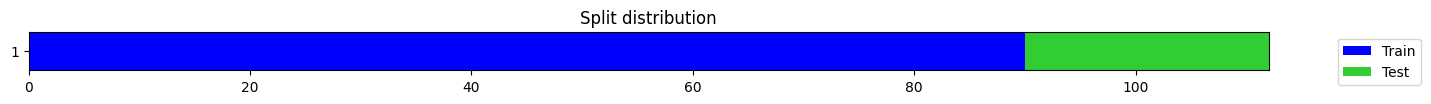

((#90) [0,1,2,3,4,5,6,7,8,9...], (#22) [90,91,92,93,94,95,96,97,98,99...])

In [6]:
splits = TimeSplitter(fcst_horizon=1)(y)
splits

In [7]:
learn = TSForecaster(X, y, splits, bs=[config.bs, 2*config.bs], batch_tfms=[],
                     seed=config.seed, arch='PatchTST', arch_config=dict())
max_lr = learn.lr_find().valley if config.max_lr is None else config.max_lr

: 

: 